In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim 
from PIL import Image
import os
from torch.utils.data import DataLoader

In [2]:
import pandas as pd
from torch.utils.data import Dataset
import skimage as ski
from skimage import io


In [3]:
class RPSDataset(Dataset):
    def __init__(self,csv_file,root_dir,transform=None):
        self.annotations =pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)
   
    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir,self.annotations.iloc[index,0])
        image = io.imread(img_path)
        y_label =torch.tensor(int(self.annotations.iloc[index,1]))

        if self.transform:
            image = self.transform(image)

        return (image,y_label)


In [4]:

# Read the CSV file into a DataFrame
file_path = 'RPSHelp.csv' 
df = pd.read_csv(file_path)

# Get the size of each column
column_sizes = df.apply(lambda col: col.size)

# Print the sizes of each column
for column, size in column_sizes.items():
    print(f"Column '{column}': {size} entries")


Column 'paper (1).png': 2187 entries
Column '0': 2187 entries


In [5]:
import torch.utils
batch_size = 32
dataset = RPSDataset(csv_file ='RPSHelp.csv',root_dir = '/Users/jacobzimmerman/Documents/Python Stuff/RockPaperScissors/RPS',transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((.5,),(.5,))]))

train_set,test_set =torch.utils.data.random_split(dataset,[1750,437])
trainloader= DataLoader(dataset=train_set, batch_size=batch_size,shuffle=True)
test_loader =DataLoader(dataset=test_set,batch_size=batch_size,shuffle=True)


In [6]:
print(train_set[0][0])

tensor([[[-0.6392, -0.6314, -0.6314,  ..., -0.0745, -0.0667, -0.0745],
         [-0.6549, -0.6392, -0.6392,  ..., -0.6157, -0.6000, -0.6078],
         [-0.6392, -0.6392, -0.6471,  ..., -0.6157, -0.6000, -0.6000],
         ...,
         [-0.6392, -0.6235, -0.6235,  ..., -0.6941, -0.7098, -0.7098],
         [-0.6235, -0.6235, -0.6235,  ..., -0.7020, -0.7098, -0.7020],
         [-0.6235, -0.6157, -0.6157,  ..., -0.7098, -0.7098, -0.7098]],

        [[ 0.1373,  0.1451,  0.1451,  ..., -0.0431, -0.0353, -0.0353],
         [ 0.1216,  0.1373,  0.1373,  ...,  0.1922,  0.2078,  0.1922],
         [ 0.1373,  0.1373,  0.1294,  ...,  0.1922,  0.2078,  0.2000],
         ...,
         [ 0.1529,  0.1686,  0.1686,  ...,  0.0667,  0.0510,  0.0510],
         [ 0.1686,  0.1686,  0.1686,  ...,  0.0588,  0.0510,  0.0588],
         [ 0.1686,  0.1765,  0.1765,  ...,  0.0510,  0.0510,  0.0510]],

        [[-0.4980, -0.4902, -0.4902,  ..., -0.5529, -0.5451, -0.5294],
         [-0.5137, -0.4980, -0.4980,  ..., -0

In [7]:
for X, y in test_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([32, 3, 200, 300])
Shape of y: torch.Size([32]) torch.int64


In [8]:
device = "cpu"

class NeuralNetwork(nn.Module):
    # def __init__(self):
    #     super().__init__()
    #     self.flatten = nn.Flatten()
    #     self.linear_relu_stack = nn.Sequential(
    #         nn.Linear(3*300*200, 512),
    #         nn.ReLU(),
    #         nn.Linear(512, 512),
    #         nn.ReLU(),
    #         nn.Linear(512, 3)
    #     )

    def __init__(self): 
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3,128,5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(128,16,5)
        self.fc1 =nn.Linear(16*47*72,120)
        self.fc2 =nn.Linear(120,84)
        self.fc3 =nn.Linear(84,3)

    # def forward(self, x):
    #     x = self.flatten(x)
    #     logits = self.linear_relu_stack(x)
    #     return logits
    def forward(self,x):
        x =self.pool(F.relu(self.conv1(x)))
        x =self.pool(F.relu(self.conv2(x)))
        x =x.view(-1,16*47*72)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x =self.fc3(x)
        return x



model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (conv1): Conv2d(3, 128, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(128, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=54144, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 8 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [12]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    test(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.100352  [   32/ 1750]
loss: 1.074515  [  288/ 1750]
loss: 0.987291  [  544/ 1750]
loss: 0.735764  [  800/ 1750]
loss: 0.896473  [ 1056/ 1750]
loss: 0.610359  [ 1312/ 1750]
loss: 0.449490  [ 1568/ 1750]
Test Error: 
 Accuracy: 85.1%, Avg loss: 0.485527 

Epoch 2
-------------------------------
loss: 0.873789  [   32/ 1750]
loss: 0.415905  [  288/ 1750]
loss: 0.395167  [  544/ 1750]
loss: 0.442561  [  800/ 1750]
loss: 0.233477  [ 1056/ 1750]
loss: 0.435386  [ 1312/ 1750]
loss: 0.206245  [ 1568/ 1750]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.325534 

Epoch 3
-------------------------------
loss: 0.074805  [   32/ 1750]
loss: 0.534478  [  288/ 1750]
loss: 0.176386  [  544/ 1750]
loss: 0.259760  [  800/ 1750]
loss: 0.185982  [ 1056/ 1750]
loss: 0.277565  [ 1312/ 1750]
loss: 0.285351  [ 1568/ 1750]
Test Error: 
 Accuracy: 90.6%, Avg loss: 0.284556 

Epoch 4
-------------------------------
loss: 0.190673  [   32/ 1750]
loss: 0.252241  [  288/ 

In [13]:
def check_accuracy(loader,model):
    num_correct =0
    num_samples =0

    with torch.no_grad():
        for x,y in loader:
            x=x.to(device=device)
            y=y.to(device=device)

            scores=model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions== y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100}')
    
    model.train()


In [14]:

print("Checking accuracy on Training Set")
check_accuracy(trainloader,model)

print("Checking accuracy on Test Set")
check_accuracy(test_loader,model)

Checking accuracy on Training Set
Got 1707 / 1750 with accuracy 97.54285714285714
Checking accuracy on Test Set
Got 413 / 437 with accuracy 94.50800915331807


In [17]:
import torch
import matplotlib.pyplot as plt
import random

def check_accuracy(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient calculation
        index = random.randint(0,len(dataset)-1)

        image, label = dataset[index]

         # Move the image and label to the specified device
        image = image.unsqueeze(0).to(device)  # Add batch dimension
        label = torch.tensor([label]).to(device)
        
        # Get the model's prediction
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        
        image = image.squeeze(0)  # Remove batch dimension
        pred = ""
        lab = ""
        if(int(predicted)==0):
            pred = "Paper"
        if(int(predicted)==1):
            pred = "Rock"
        if(int(predicted)==2):
            pred = "Scissors" 
        if(int(label)==0):
            lab = "Paper"
        if(int(label)==1):
            lab = "Rock"
        if(int(label)==2):
            lab = "Scissors"
        
        # Display the image
        img = image.permute(1, 2, 0).numpy()  # Convert tensor to numpy array and permute dimensions
        plt.imshow(img)
        plt.title(f"Prediction: {pred}, Actual: {lab}")
        plt.axis('off')  # Hide axes
        plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


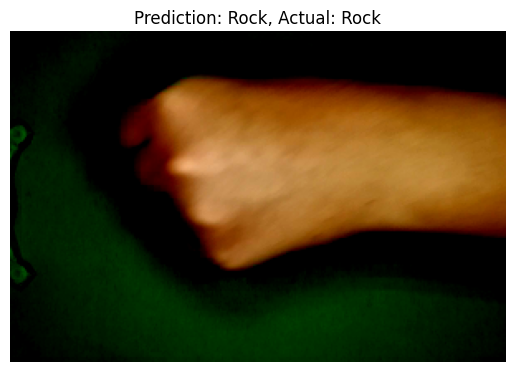

In [47]:
check_accuracy(model,test_loader,device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


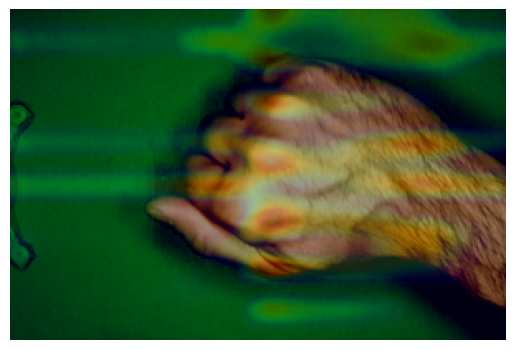

In [58]:
model.eval()

index = random.randint(0,len(dataset)-1)
image, label = dataset[index]
image1 = image.permute(1, 2, 0).numpy()



output = model(image)
# Get the image tensor
img_tensor = image

# Hook to extract the features and gradients
gradients = []
features = []

def save_gradient(grad):
    gradients.append(grad)

def forward_hook(module, input, output):
    features.append(output)
    output.register_hook(save_gradient)  # Register backward hook

# Register hook to the last convolutional layer
last_conv_layer = model.conv2
hook_handle = last_conv_layer.register_forward_hook(forward_hook)

# Forward pass
output = model(img_tensor)
hook_handle.remove()  # Remove hook after forward pass

# Backward pass
output_idx = torch.argmax(output, dim=1).item()
model.zero_grad()
output[:, output_idx].backward()

# Get gradients and features
gradients = gradients[0]
features = features[0]

# Compute the weights
weights = torch.mean(gradients, dim=(-3, 2), keepdim=True)

# Generate the Grad-CAM heatmap
grad_cam = torch.relu(torch.sum(weights * features, dim=1)).squeeze().cpu().detach().numpy()
grad_cam = grad_cam - np.min(grad_cam)
grad_cam = grad_cam / np.max(grad_cam)

# Resize the heatmap and overlay on the original image
image = img_tensor.squeeze(0)
img = image.permute(1, 2, 0).numpy()
heatmap = Image.fromarray(np.uint8(255 * grad_cam)).resize((img.shape[1], img.shape[0]), Image.LANCZOS)
heatmap = np.array(heatmap)

# Apply colormap
heatmap = np.uint8(255 * plt.cm.jet(heatmap)[..., :3])
superimposed_img = np.array(img) * 0.6 + heatmap * 0.4
superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

# Display the result
fig, ax = plt.subplots()
ax.imshow(image1)
plt.imshow(superimposed_img,alpha =.4)
plt.axis('off')
plt.show()
